# ERA5 at glacier locations

Code and data used to generate data for our [Glacier Explorer](http://edu.oggm.org/en/latest/explorer.html)

In [1]:
# Data wrangling libs
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
# Just for download and fancy bar
from oggm import utils
import progressbar
# Plots
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation 

### 2m temperature, annual averages, 1979-2018 (40 years)

Data downloaded from ECMWF and stored here for convenience:

In [2]:
f_era = utils.file_downloader('https://cluster.klima.uni-bremen.de/~fmaussion/climate/era5/monthly/v1.0/era5_monthly_t2m_1979-2018.nc')
ds = xr.open_dataset(f_era).chunk(chunks={'time':12})
ds

No known hash for cluster.klima.uni-bremen.de/~fmaussion/climate/era5/monthly/v1.0/era5_monthly_t2m_1979-2018.nc


<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 480)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<shape=(480, 721, 1440), chunksize=(12, 721, 1440)>
Attributes:
    Conventions:  CF-1.6
    history:      2019-05-26 11:47:21 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

We work we annual averages only:

In [3]:
ds = ds.resample(time='AS').mean(dim='time')

For analysis of *changes*, we compute the anomaly to the first decade in the dataset as reference.

In [4]:
ds['t2m_ano'] = ds['t2m'] - ds['t2m'].sel(time=slice('1979', '1988')).mean(dim='time')

### ERA5 invariant fields: landmask and altitude 

In [5]:
f_era = utils.file_downloader('https://cluster.klima.uni-bremen.de/~fmaussion/climate/era5/monthly/v1.0/era5_invariant.nc')
ds_inv = xr.open_dataset(f_era).isel(time=0)
ds_inv

No known hash for cluster.klima.uni-bremen.de/~fmaussion/climate/era5/monthly/v1.0/era5_invariant.nc


<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 1979-01-01
Data variables:
    lsm        (latitude, longitude) float32 ...
    z          (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-08-19 17:31:31 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [6]:
# Convert geop to elevation
ds_inv['z'] = (ds_inv['z'] / 9.80665)

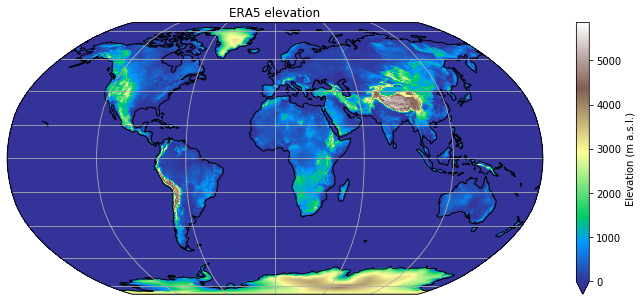

In [7]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())
ds_inv['z'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='terrain', vmin=0, cbar_kwargs={'label':'Elevation (m a.s.l.)'}) 
ax.coastlines(); ax.gridlines(); ax.set_title('ERA5 elevation'); 

### Glacier location and area

We download data from the [Randolph Glacier Inventory (RGI 6.0)](https://www.glims.org/RGI/), pre-processed in tabular form:

In [8]:
# RGI statistics as csv
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~fmaussion/misc/rgi62_allglaciers.csv')
odf = pd.read_csv(frgi, index_col=0,
                  converters={'Name':str, 'GLIMSId': str, 'BgnDate':str, 'EndDate':str, 
                              'O1Region': str, 'O2Region':str, 
                              'IsTidewater':bool, 'IsNominal':bool})

No known hash for cluster.klima.uni-bremen.de/~fmaussion/misc/rgi62_allglaciers.csv


Some data wrangling to locate the ERA5 grid points where we have glaciers:

In [9]:
nx, ny = ds.dims['longitude'], ds.dims['latitude']
# Nearest neighbor lookup
cenlon_for_bins = np.where(odf['CenLon'] < -0.125, odf['CenLon']+360, odf['CenLon'])
lon_bins = np.linspace(-0.125, 359.75+0.125, nx)
lat_bins = np.linspace(90+0.125, -90-0.125, ny)
odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1
# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of ERA5 gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

Total number of glaciers: 216502 and number of ERA5 gridpoints with glaciers in them: 11323


### 2D masks for mapping and weighted averages 

Glacier locations and corresponding weights:

In [10]:
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area']
ds['glacier_mask'] = (('latitude', 'longitude'), np.isfinite(mask))
ds['glacier_area'] = (('latitude', 'longitude'), mask)
ds['weight_glacier'] = (('latitude', 'longitude'), mask / np.nansum(mask))

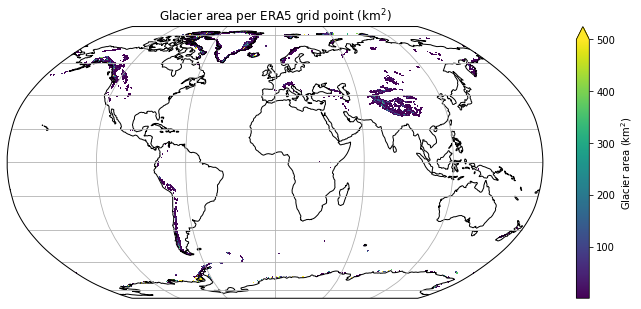

In [11]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())
ds['glacier_area'].plot(ax=ax, transform=ccrs.PlateCarree(), vmax=500, 
                        cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
ax.coastlines(); ax.gridlines(); ax.set_title('Glacier area per ERA5 grid point (km$^{2}$)');

The Earth is not flat: take this into account as well:

In [12]:
# Weight
weight = np.cos(np.deg2rad(ds.latitude)).clip(0)
weight =  ds.t2m.isel(time=0) * 0. + weight
ds['weight'] = (('latitude', 'longitude'), weight / weight.sum())
weight =  ds['weight'].where(ds_inv['lsm'] > 0.5)
ds['weight_land'] = weight / weight.sum().data
weight =  ds['weight'].where(ds_inv['lsm'] < 0.5)
ds['weight_ocean'] = weight / weight.sum().data

### Temperature trends at each single location 

In [13]:
# Data containers
trends = np.full((ny, nx), np.NaN)
p_values = np.full((ny, nx), np.NaN)
trends_std_err = np.full((ny, nx), np.NaN)

# Things we are going to regress onto
x = np.asarray(ds['time.year'])
y = ds['t2m'].values

# Good old for loop
for j in progressbar.progressbar(range(ny)):
    for i in range(nx):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y[:, j, i])
        trends[j, i] = slope
        p_values[j, i] = p_value
        trends_std_err[j, i] = std_err

# Back to xarray
ds['trend'] = (('latitude', 'longitude'), trends * 10)
ds['trend_std_err'] = (('latitude', 'longitude'), trends_std_err * 10)
ds['trend_p_values'] = (('latitude', 'longitude'), p_values)

100% (721 of 721) |######################| Elapsed Time: 0:03:15 Time:  0:03:15


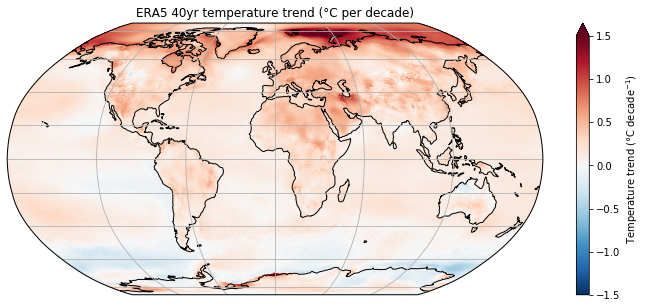

In [15]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())
ds['trend'].plot(ax=ax, transform=ccrs.PlateCarree(), vmax=1.5,
                 cbar_kwargs={'label':'Temperature trend (°C decade$^{-1}$)'}) 
ax.coastlines(); ax.gridlines(); ax.set_title('ERA5 40yr temperature trend (°C per decade)');

### Add precip  

In [24]:
f_era = utils.file_downloader('https://cluster.klima.uni-bremen.de/~fmaussion/climate/era5/monthly/v1.0/era5_monthly_prcp_1979-2018.nc')
ds_p = xr.open_dataset(f_era).chunk(chunks={'time':12})
ds_p

No known hash for cluster.klima.uni-bremen.de/~fmaussion/climate/era5/monthly/v1.0/era5_monthly_prcp_1979-2018.nc


<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 480)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<shape=(480, 721, 1440), chunksize=(12, 721, 1440)>
Attributes:
    Conventions:  CF-1.6
    history:      2019-05-26 11:39:56 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [25]:
ds_p.tp

<xarray.DataArray 'tp' (time: 480, latitude: 721, longitude: 1440)>
dask.array<shape=(480, 721, 1440), dtype=float32, chunksize=(12, 721, 1440)>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Attributes:
    units:      m
    long_name:  Total precipitation

From the ERA5 doc on [monhtly means](https://confluence.ecmwf.int/display/CKB/ERA5+data+documentation#ERA5datadocumentation-Monthlymeans):

Accumulations are described in section Mean rates and accumulations. The accumulations in monthly means of daily means (stream=moda/edmo) have been scaled to have units that include "per day", so for accumulations in these streams:

    The hydrological parameters are in units of "m of water per day" and so they should be multiplied by 1000 to convert to kg m-2 day-1 or mm day-1.

Convert:

In [36]:
tp = ds_p.tp * ds_p['time.daysinmonth'] * 1000.

In [38]:
tp = tp.resample(time='AS').sum(dim='time')

In [40]:
tp.attrs['units'] = 'mm yr-1'

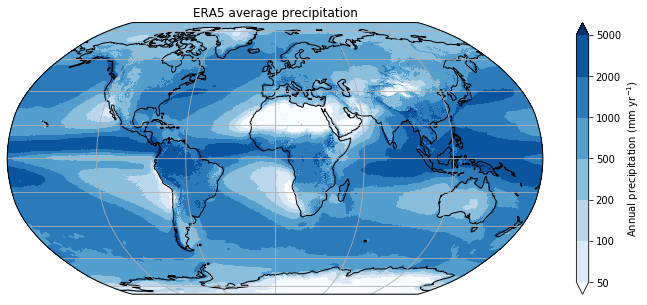

In [43]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())
tp.mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree(), levels=[50, 100, 200, 500, 1000, 2000, 5000],
                         cbar_kwargs={'label':'Annual precipitation (mm yr$^{-1}$)'}, cmap='Blues') 
ax.coastlines(); ax.gridlines(); ax.set_title('ERA5 average precipitation');

In [45]:
ds['pcp'] = tp
ds['pcp_ano'] = ds['pcp'] / ds['pcp'].sel(time=slice('1979', '1988')).mean(dim='time')

### Merge with invariant

In [69]:
ds['surface_elev'] = ds_inv['z']
ds['landmask'] = ds_inv['lsm']

### Flatten data and store for later use 

In [70]:
dss = ds.isel(longitude=('zone_id', mdf['lon_id']), latitude=('zone_id', mdf['lat_id']))
dss['zone_id'] = ('zone_id', mdf.index.values)

In [71]:
dss

<xarray.Dataset>
Dimensions:         (time: 40, zone_id: 11323)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2018-01-01
    longitude       (zone_id) float32 213.0 213.25 213.75 ... 322.75 269.5 37.75
    latitude        (zone_id) float32 63.75 63.5 63.5 ... -54.25 -68.75 -46.75
  * zone_id         (zone_id) object '852_105' '853_106' ... '151_547'
Data variables:
    t2m             (time, zone_id) float32 dask.array<shape=(40, 11323), chunksize=(1, 11323)>
    t2m_ano         (time, zone_id) float32 dask.array<shape=(40, 11323), chunksize=(1, 11323)>
    glacier_mask    (zone_id) bool True True True True ... True True True True
    glacier_area    (zone_id) float64 28.53 561.1 48.82 ... 5.547 0.011 0.528
    weight_glacier  (zone_id) float64 3.824e-05 0.0007521 ... 7.077e-07
    weight          (zone_id) float64 6.701e-07 6.76e-07 ... 5.491e-07 1.038e-06
    weight_land     (zone_id) float64 2.322e-06 2.342e-06 2.342e-06 ... nan nan
    weight_ocea

In [75]:
np.testing.assert_allclose(dss.weight_glacier.sum(), 1)
np.testing.assert_allclose(dss.glacier_area.sum(), odf.Area.sum())

In [76]:
dss = dss[['t2m', 'pcp', 'surface_elev', 'landmask', 'glacier_area', 'trend', 'trend_std_err', 'trend_p_values']]

In [83]:
dss['t2m'].attrs['units'] = 'K'
dss['t2m'].attrs['long_name'] = '2m air temperature'

dss['surface_elev'].attrs['units'] = 'm'
dss['surface_elev'].attrs['long_name'] = 'ERA5 surface elevation'

dss['glacier_area'].attrs['units'] = 'km2'
dss['glacier_area'].attrs['long_name'] = 'Total glacier area in grid-point'

dss['pcp'].attrs['long_name'] = 'Total precipitation'

dss['trend'].attrs['units'] = 'K decade-1'
dss['trend'].attrs['long_name'] = '40yr 2mtemperature trend'
dss['trend_std_err'].attrs['units'] = 'K decade-1'
dss['trend_std_err'].attrs['long_name'] = '40yr 2mtemperature trend standard error'
dss['trend_p_values'].attrs['units'] = '-'
dss['trend_p_values'].attrs['long_name'] = '40yr 2mtemperature trend p-value'

dss['zone_id'].attrs['units'] = '-'
dss['zone_id'].attrs['long_name'] = 'Zone in ERA5 as lon index - lat index'

dss.attrs['info'] = 'Annual ERA5 data extracted at all glacier locations'
dss.attrs['author'] = 'fabien.maussion@uibk.ac.at'
import datetime
dss.attrs['date'] = datetime.date.today().strftime("%Y-%m-%d")

In [84]:
dss.info()

xarray.Dataset {
dimensions:
	time = 40 ;
	zone_id = 11323 ;

variables:
	float32 t2m(time, zone_id) ;
		t2m:units = K ;
		t2m:long_name = 2m air temperature ;
	float64 pcp(time, zone_id) ;
		pcp:units = mm yr-1 ;
		pcp:long_name = Total precipitation ;
	float32 surface_elev(zone_id) ;
		surface_elev:units = m ;
		surface_elev:long_name = ERA5 surface elevation ;
	float32 landmask(zone_id) ;
		landmask:units = (0 - 1) ;
		landmask:long_name = Land-sea mask ;
		landmask:standard_name = land_binary_mask ;
	float64 glacier_area(zone_id) ;
		glacier_area:units = km2 ;
		glacier_area:long_name = Total glacier area in grid-point ;
	float64 trend(zone_id) ;
		trend:units = K decade-1 ;
		trend:long_name = 40yr 2mtemperature trend ;
	float64 trend_std_err(zone_id) ;
		trend_std_err:units = K decade-1 ;
		trend_std_err:long_name = 40yr 2mtemperature trend standard error ;
	float64 trend_p_values(zone_id) ;
		trend_p_values:units = - ;
		trend_p_values:long_name = 40yr 2mtemperature trend p-valu

In [85]:
dss.to_netcdf('era5_annual_glacierloc_1979-2018.nc')